# ASPEN paper - Figure 2 and its supplement

Loading required R libraries.

In [69]:
suppressPackageStartupMessages({
    library(openxlsx)
    library(scales)
    library(scater)
    library(dplyr)
    library(gamlss)
    library(ggplot2)
    library(ggpointdensity)
    library(ggsci)
    library(ggthemes)
    library(gridExtra)
    library(ggpubr)
    library(scales)
    library(foreach)
    library(reshape2)
    library(locfit)
    library(scran)
    library(zoo)
    library(MatchIt)
    library(coin)
    library(clusterProfiler)
    library(org.Mm.eg.db)
})

Functions that will be used to generate the plots.

In [36]:
#Functions
plot_scatter <- function(param_reestim){

  ggplot(param_reestim, aes(log(tot_gene_mean), log(bb_theta))) +
    geom_point(size = 0.7, colour = "darkgrey") +
    geom_line(aes(log(tot_gene_mean), log(theta_common)), color = "black", linewidth = 1, group = 1) +
    theme_classic(base_size = 20) +
    theme(legend.position = "none", legend.title = element_blank()) +
    annotate("text", x=2, y=1, label= paste("N genes:", nrow(param_reestim)), size = 6) 
}

plot_disp_fit_theta <- function(param_reestim, midpoint = 2000, gene = gene){
    
    ggplot(param_reestim, aes(log(tot_gene_mean), log(theta_reestim))) +
        geom_pointdensity(size = 0.7) +
        geom_smooth(data = param_reestim[param_reestim$theta_reestim > 1e-03,], method = "locfit", color = "#01a2d9", linewidth = 0.7, se = F) +
        theme_classic(base_size = 20) +
        theme(legend.position = "none", legend.title = element_blank()) +
        scale_color_gradient2(low = "#003C67FF", mid = "#EFC000FF", high = "#A73030FF", midpoint = midpoint) +
        annotate("text", x=2, y=1, label= paste("N genes:", nrow(param_reestim)))  
}

boxplot <- function(plot_data){
  
      compare <- list(c("low disp", "background"))  
      plot_data$logcounts <- log(as.numeric(plot_data$bb_theta))
    
      p <- ggboxplot(plot_data, x = "group", y = "logcounts", ylab = paste0("log(theta)"),  
                ggtheme=theme_pubr(base_size = 20), #fill = "allele", #palette = "Dark2",
                palette = ggthemes_data$excel$themes$Badge$accents) + #, caption = "Mann-Whitney U test") +
        theme(legend.position = "right", legend.title = element_blank(), axis.title.y = element_blank(),
             axis.title.x = element_blank()) +
        stat_compare_means(comparison = compare, label.y = 2, size= 6) +
        ylim(c(-10,3.5))
        p

}

### Scatterplots

Loading ASPEN results for bulk and single-cell data

In [73]:
res_dir <- "./aspen_output/tcells/"
samples <- list("cd8_nav_real_bulk", "cd8_d07_real_bulk")
bb_test_res_bulk <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_allelicimb_bulk.xlsx"),
                                                            sheet = q, rowNames = T))
#scRNA results
samples <- list("cd8_naive", "cd8_d07_lcmv_arms", "cd8_d40_lcmv_arms")
bb_test_res_tcells <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_lcmv_ASPENmean.xlsx"),
                                                            sheet = q, rowNames = T))

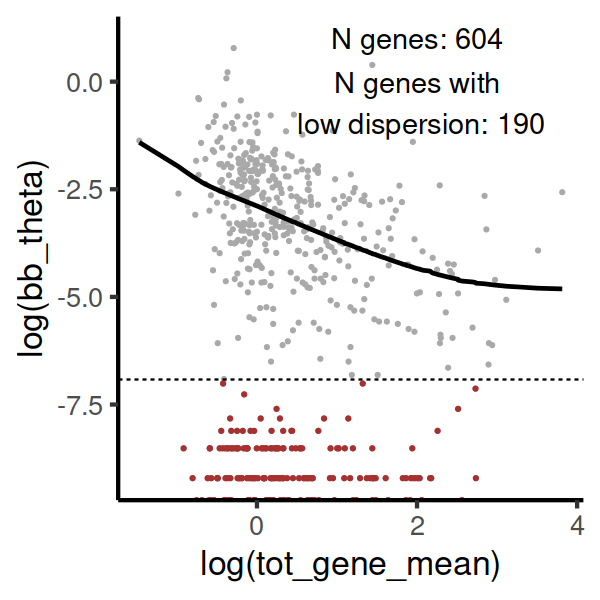

In [25]:
options(repr.plot.width = 5, repr.plot.height = 5)
#Comparison is performed for d07 post infection
plot_scatter(bb_test_res_tcells[[2]]) +
    geom_point(data = subset(bb_test_res_tcells[[2]], bb_theta < 1e-03), colour = "#A73030FF", size = 0.7) +
    annotate("text", x=2, y=-0.5, label= paste("N genes with\n low dispersion:", table(bb_test_res_tcells[[2]]$bb_theta < 1e-03)[2]), size = 6) +
    geom_hline(yintercept = log(1e-03), linetype = "dashed")

In [45]:
#Adding dispersion estimations in scRNA to the bulk RNA data
bb_test_res_bulk[[2]]$theta_scRNA <- bb_test_res_tcells[[2]]$bb_theta[match(rownames(bb_test_res_bulk[[2]]), rownames(bb_test_res_tcells[[2]]))]
#adding trend line
bb_test_res_bulk[[2]] <- bb_test_res_bulk[[2]][order(bb_test_res_bulk[[2]]$tot_gene_mean),]
bb_test_res_bulk[[2]]$theta_common <- na.approx(bb_test_res_bulk[[2]]$theta_smoothed, na.rm = FALSE)
#renaming column with theta estimates
colnames(bb_test_res_bulk[[2]])[10] <- "bb_theta"

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


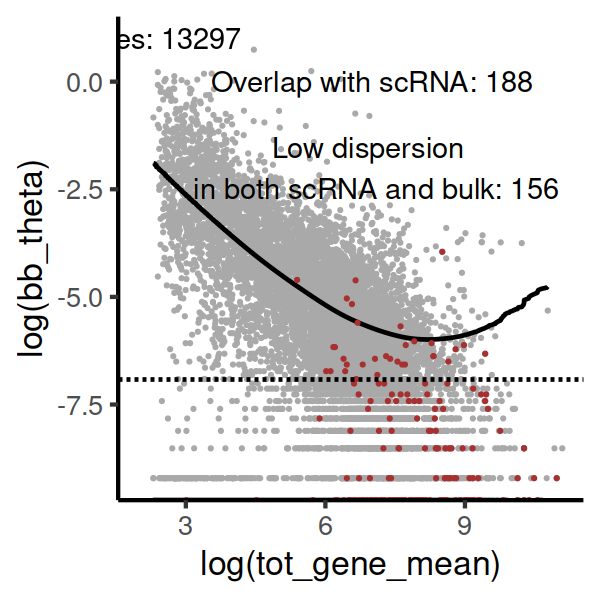

In [21]:
plot_scatter(bb_test_res_bulk[[2]]) +
    geom_point(data = subset(bb_test_res_bulk[[2]], theta_scRNA < 1e-03), colour = "#A73030FF", size = 0.7) +
    annotate("text", x=7, y=0, label= paste("Overlap with scRNA:", table(bb_test_res_bulk[[2]]$theta_scRNA < 1e-03)[2]), size = 6) +
    annotate("text", x=7, y=-2, label= paste("Low dispersion \n in both scRNA and bulk:", table(bb_test_res_bulk[[2]]$bb_theta < 1e-03, 
                                                                                                bb_test_res_bulk[[2]]$theta_scRNA < 1e-03)[4]), size = 6) +
    geom_hline(yintercept = log(1e-03), linetype = "dashed", linewidth = 1)

### Boxplots

Dispersion estimates in scRNA data are compared with the estimates for other genes, matched by gene expression levels. To find the matching set of genes, the mean gene expression is divided into five equal-sized bins.

In [103]:
#adding GE bins
bb_test_res_tcells[[2]]$GEbin <- cut(bb_test_res_tcells[[2]]$tot_gene_mean, breaks=c(quantile(bb_test_res_tcells[[2]]$tot_gene_mean, probs = seq(0, 1, by = 0.2))))
bb_test_res_tcells[[2]]$GEbin[is.na(bb_test_res_tcells[[2]]$GEbin)] <- levels(bb_test_res_tcells[[2]]$GEbin)[1]
levels(bb_test_res_tcells[[2]]$GEbin) <- c(1, 2, 3, 4, 5)
bb_test_res_tcells[[2]]$low_disp <- ifelse(bb_test_res_tcells[[2]]$bb_theta < 1e-03, 1, 0)

In [29]:
#MatchIt function is used to find genes with similar expression levels
set.seed(10011011)
match.out <- matchit(low_disp ~ GEbin, data = bb_test_res_tcells[[2]],
                     method = "nearest", distance = "glm")
matched_genes <- as.data.frame(match.out[["match.matrix"]])
colnames(matched_genes) <- "gene_id"
head(matched_genes)

,gene_id
,<chr>
Ptpn18,Il18r1
Cox5b,Rabgap1l
Ankrd44,Cd247
Rpl37a,Rpl31
Sp100,Stat4
Ptma,Dock10


In [30]:
#combining genes with low dispersion and their matches into one vector
genes_select <- c(rownames(matched_genes), matched_genes$gene_id)
length(genes_select)

[1] 380

In [42]:
bb_test_res_tcells[[2]]$group <- ifelse(bb_test_res_tcells[[2]]$bb_theta < 1e-03, "low disp", "background")
bb_test_res_tcells[[2]]$group <- factor(bb_test_res_tcells[[2]]$group, levels = c("low disp", "background"))

Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_signif()`).”


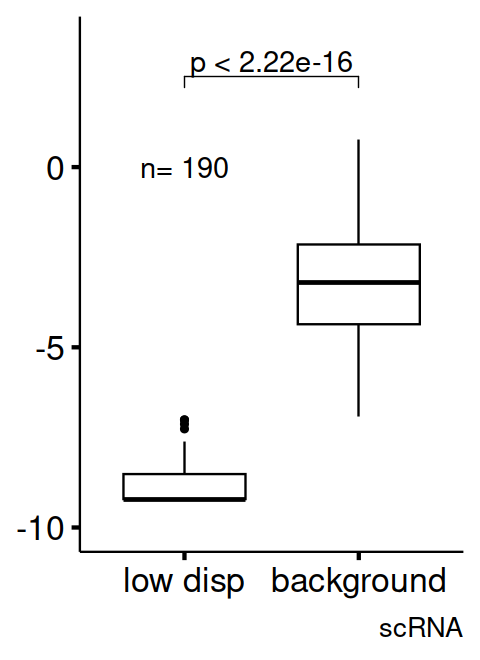

In [55]:
options(repr.plot.width = 4, repr.plot.height = 5.5)
tcells_sub <- bb_test_res_tcells[[2]][genes_select,]
boxplot(tcells_sub) +
    annotate("text", x=1, y=0, label= paste("n=", dim(tcells_sub)[1]/2), size = 6) +
    labs(caption = "scRNA")

Comparing the dispersion estimates in bulk data between the genes found to be low-dispersed in scRNA and the background genes (matched by gene expression levels).

In [46]:
#adding group definition
bb_test_res_bulk[[2]]$group <- ifelse(bb_test_res_bulk[[2]]$theta_scRNA < 1e-03, "low disp", "background")
#adding group that are not expressed in scRNA into background too
bb_test_res_bulk[[2]]$group[is.na(bb_test_res_bulk[[2]]$group)] <- "background"
table(bb_test_res_bulk[[2]]$group)


background   low disp 
     13109        188 

In [47]:
#repeating as dichotomous covariates for the MatchIt model
bb_test_res_bulk[[2]]$low_disp <- ifelse(bb_test_res_bulk[[2]]$theta_scRNA < 1e-03, 1, 0)
bb_test_res_bulk[[2]]$low_disp[is.na(bb_test_res_bulk[[2]]$low_disp)] <- 0
table(bb_test_res_bulk[[2]]$low_disp)


    0     1 
13109   188 

In [49]:
#adding GE bins
bb_test_res_bulk[[2]]$GEbin <- cut(bb_test_res_bulk[[2]]$tot_gene_mean, breaks=c(quantile(bb_test_res_bulk[[2]]$tot_gene_mean, probs = seq(0, 1, by = 0.2))))
bb_test_res_bulk[[2]]$GEbin[is.na(bb_test_res_bulk[[2]]$GEbin)] <- levels(bb_test_res_bulk[[2]]$GEbin)[1]
levels(bb_test_res_bulk[[2]]$GEbin) <- c(1, 2, 3, 4, 5)

In [50]:
set.seed(10011011)
match.out <- matchit(low_disp ~ GEbin, data = bb_test_res_bulk[[2]],
                     method = "nearest", distance = "glm")
matched_genes <- as.data.frame(match.out[["match.matrix"]])
colnames(matched_genes) <- "gene_id"
head(matched_genes)

,gene_id
,<chr>
H2ac20,Slc39a1
Nap1l1,Zfp788
Rpl9,Nudt14
Rps29,Gm47003
Tomm7,5530601H04Rik
Rpl38,Prpf3


In [63]:
#combining genes with low dispersion and their matches into one vector
genes_select <- c(rownames(matched_genes), matched_genes$gene_id)
length(genes_select)
tcells_sub <- bb_test_res_tcells[[2]][genes_select,]

[1] 376

Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_signif()`).”


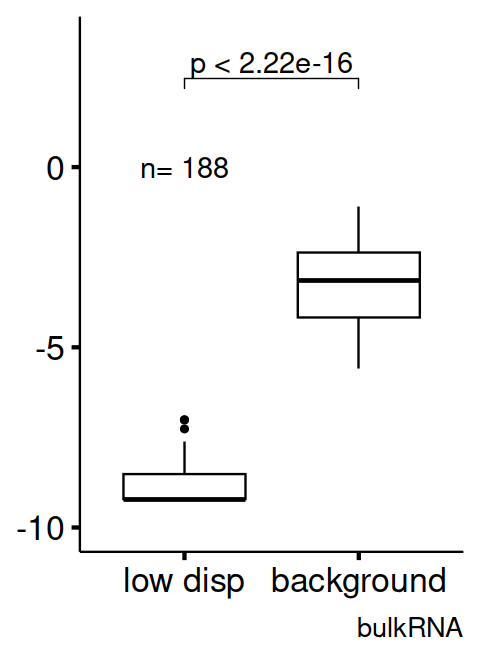

In [64]:
options(repr.plot.width = 4, repr.plot.height = 5.5)
boxplot(tcells_sub[!is.na(tcells_sub$group),]) +
annotate("text", x=1, y=0, label= paste("n=", dim(tcells_sub)[1]/2), size = 6) +
    labs(caption = "bulkRNA")

In [65]:
#package coin is used to extract wilcoxon z-value
wilcox_test(log(bb_theta) ~ group, data = tcells_sub)


	Asymptotic Wilcoxon-Mann-Whitney Test

data:  log(bb_theta) by group (low disp, background)
Z = -8.7891, p-value < 2.2e-16
alternative hypothesis: true mu is not equal to 0


### Supplementary Figures

In [ ]:
GO analyses on genes with low dispersion. 

In [74]:
bb_test_res_tcells <- lapply(bb_test_res_tcells, function(q) {q$group <- ifelse(q$bb_theta < 1e-03, "low disp", "background");
                                                              return(q)})
bb_test_res_tcells_split <- lapply(bb_test_res_tcells, function(q) split(q, f = q$group))
bkg_genes <- lapply(bb_test_res_tcells, function(q) bitr(rownames(q), fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)) 
low_disp_genes <- lapply(bb_test_res_tcells_split, function(q) bitr(rownames(q[["low disp"]]), fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db))

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(q), fromType = c("SYMBOL"), toType = "ENTREZID", :
“0.9% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(q), fromType = c("SYMBOL"), toType = "ENTREZID", :
“1.16% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(q), fromType = c("SYMBOL"), toType = "ENTREZID", :
“1.03% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(q[["low disp"]]), fromType = c("SYMBOL"), toType = "ENTREZID", :
“0.53% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(q[["low disp"]]), fromType = c("SYMBOL"), toType = "ENTREZID", :
“0.96% of input gene IDs 

In [96]:
bkg_genes_comb <- do.call(rbind, bkg_genes)
low_disp_genes_comb <- do.call(rbind, low_disp_genes)
bkg_genes_comb <- bkg_genes_comb[!duplicated(bkg_genes_comb$SYMBOL),]
low_disp_genes_comb <- low_disp_genes_comb[!duplicated(low_disp_genes_comb$SYMBOL),]

In [97]:
ego_sets_lowdisp <- enrichGO(gene = low_disp_genes_comb$ENTREZID,
                             universe = bkg_genes_comb$ENTREZID,
                             OrgDb = org.Mm.eg.db,
                             ont = "BP", #"MF",
                             pAdjustMethod = "BH",
                             pvalueCutoff  = 1,
                             qvalueCutoff  = 0.2,
                             readable = TRUE)


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


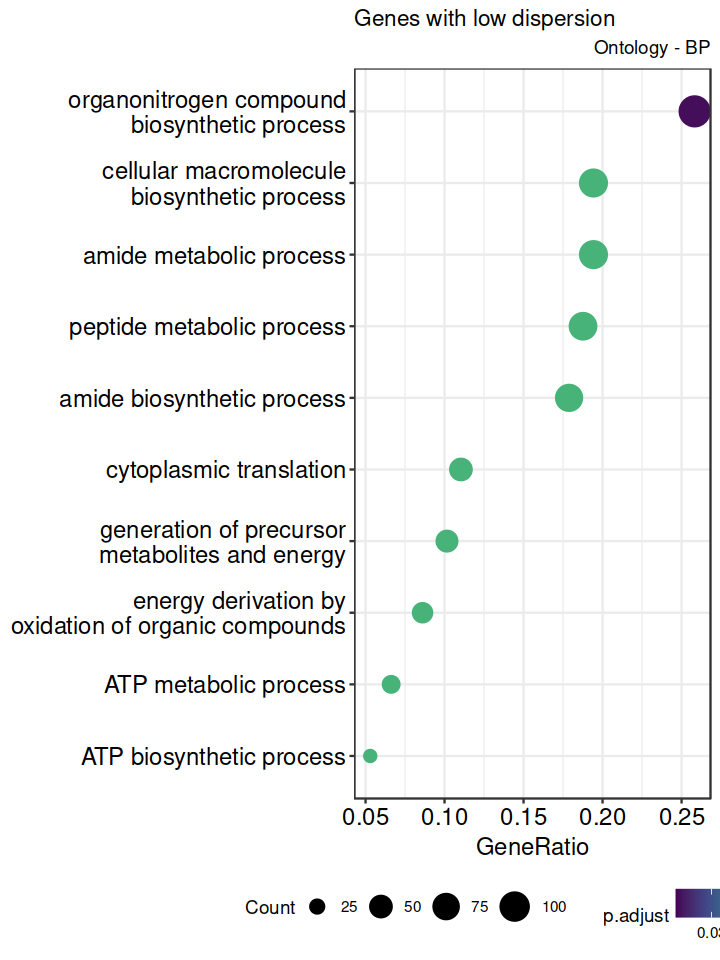

In [98]:
options(repr.plot.width = 6, repr.plot.height = 8)
dotplot(ego_sets_lowdisp, showCategory = 10, font.size=14)  +
        scale_colour_viridis_c(limits=c(1e-04, 0.12)) +
        theme(legend.position = "bottom", plot.subtitle = element_text(hjust = 1)) +
        labs(subtitle = "Ontology - BP", title = "Genes with low dispersion")



Checking dispersion estimates for the genes important for the T-cells expansion.

In [99]:
# Loading a list of genes essential for Tcells - obtained from Zhao, et al. (2021) Cell Reports
essen_genes  <- read.xlsx("./misc/genes_essential_Tcells.xlsx", colNames = F)
head(essen_genes)

,X1
,<chr>
1,1700011E24Rik
2,Bcl9l
3,Tenm2
4,Nmbr
5,Kdm8
6,C1qtnf4


In [100]:
#identifying essential genes in the T cells D07
bb_test_res_tcells[[2]]$essent <- ifelse(rownames(bb_test_res_tcells[[2]]) %in% essen_genes$X1, 1, 0)
table(bb_test_res_tcells[[2]]$essent)


  0   1 
394 210 

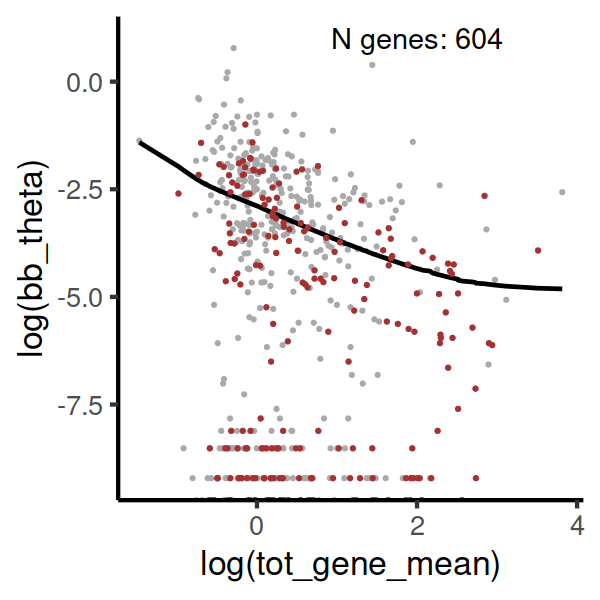

In [102]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot_scatter(bb_test_res_tcells[[2]]) +
    geom_point(data = subset(bb_test_res_tcells[[2]], essent == 1), colour = "#A73030FF", size = 0.7)

In [119]:
set.seed(10011011)
match.out <- matchit(essent ~ GEbin, data = bb_test_res_tcells[[2]],
                     method = "nearest", distance = "glm")
matched_genes <- as.data.frame(match.out[["match.matrix"]])
colnames(matched_genes) <- "gene_id"
head(matched_genes)
dim(matched_genes)

,gene_id
,<chr>
Rpl31,Dock10
Rpl37a,Ptprc
Arpc2,Vim
Ncl,Aff3
Ptma,Arhgap15
Actr3,Cops9


[1] 210   1

In [120]:
#combining genes with low dispersion and their matches into one vector
genes_select <- c(rownames(matched_genes), matched_genes$gene_id)
length(genes_select)

[1] 420

In [106]:
tcells_sub <- bb_test_res_tcells[[2]][genes_select,]
tcells_sub$group <- ifelse(tcells_sub$essent == 1, "essential \n for T-cells", "non-essential")

In [110]:
boxplot <- function(plot_data){
  #data for the boxplot
      compare <- list(c("essential \n for T-cells", "non-essential"))  
      plot_data$logcounts <- log(as.numeric(plot_data$bb_theta))
    
      p <- ggboxplot(plot_data, x = "group", y = "logcounts", ylab = paste0("log(theta)"),  
                ggtheme=theme_pubr(base_size = 20), #fill = "allele", #palette = "Dark2",
                palette = ggthemes_data$excel$themes$Badge$accents) + #, caption = "Mann-Whitney U test") +
        theme(legend.position = "right", legend.title = element_blank(), axis.title.y = element_blank(),
             axis.title.x = element_blank()) +
        stat_compare_means(comparison = compare, label.y = 2, size= 6) +
        ylim(c(-10,4.5))
        p
}

Warning message:
“Removed 38 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 38 rows containing non-finite outside the scale range
(`stat_signif()`).”


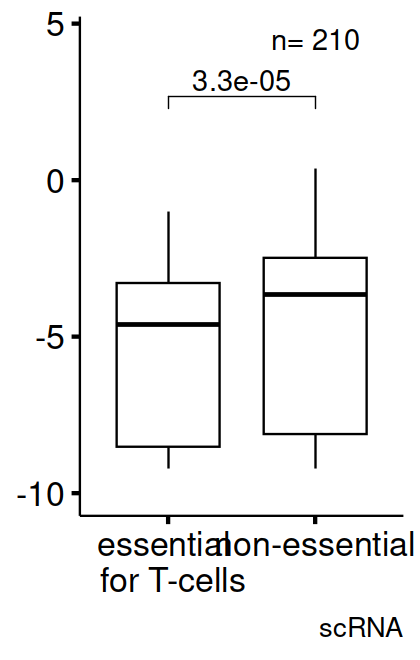

In [121]:
options(repr.plot.width = 3.5, repr.plot.height = 5.5)
boxplot(tcells_sub) +
    annotate("text", x=2, y=4.5, label= paste("n=", dim(tcells_sub)[1]/2), size = 6) +
    labs(caption = "scRNA", y = "Dispersion, log(theta)")

In [122]:
#package coin is used to extract wilcoxon z-value
tcells_sub$group <- as.factor(tcells_sub$group)
wilcox_test(log(bb_theta) ~ group, data = tcells_sub)


	Asymptotic Wilcoxon-Mann-Whitney Test

data:  log(bb_theta) by
	 group (essential 
 for T-cells, non-essential)
Z = -4.15, p-value = 3.324e-05
alternative hypothesis: true mu is not equal to 0
